In [3]:
%matplotlib inline
import sys
import glob
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import os
import time
from lmfit import Parameter, Parameters, Minimizer, fit_report
from lsst.obs.lsst import LsstCamMapper as camMapper
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms
from scipy.spatial import ConvexHull, convex_hull_plot_2d, distance

sys.path.insert(0,'/home/abrought/mixcoatl/python/mixcoatl/')
sys.path.insert(0,'/home/abrought/mixcoatl/python/')
from mixcoatl.gridFitTask import GridFitTask, DistortedGrid, fit_check
from mixcoatl.sourcegrid import coordinate_distances, fit_error

camera = camMapper._makeCamera()
lct = LsstCameraTransforms(camera)

# Example #1

Fit results: 
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 386
    # variables        = 2
    chi-square         = 199.924289
    reduced chi-square = 0.52063617
    Akaike info crit   = -249.948870
    Bayesian info crit = -242.037196
[[Variables]]
    ystep:  65.77793 (fixed)
    xstep:  65.7919 (fixed)
    y0:    -88.2473286 +/- 0.06116574 (0.07%) (init = -88.71573)
    x0:     326.036287 +/- 0.05236106 (0.02%) (init = 327.992)
    theta:  0.67011908 +/- 5.8695e-05 (0.01%) (init = 0.6699238)
[[Correlations]] (unreported correlations are < 0.100)
    C(y0, x0) = -0.384


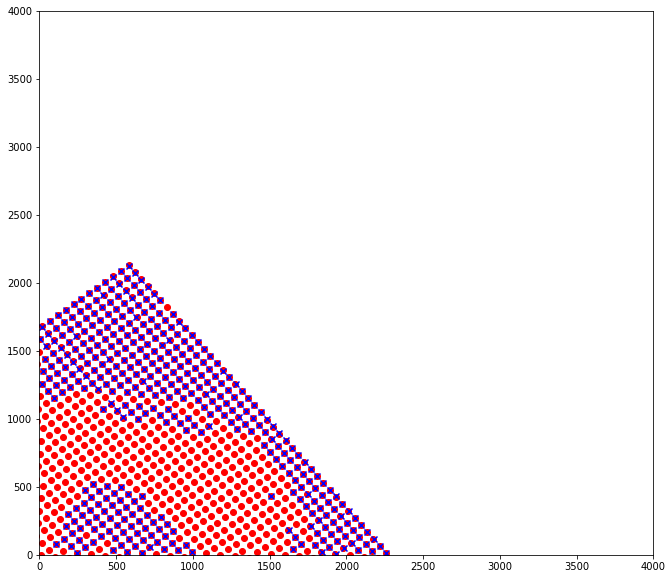

In [4]:
i = 100
infile = glob.glob("/home/abrought/DATA/12784_dither/*.cat")[i]

gridfit_task = GridFitTask()
gridfit_task.config.vary_theta = True
gridfit_task.config.outfile = 'test_gridspacing_distorted_grid.fits'

grid, result = gridfit_task.run(infile, ccd_type='E2V')
gY, gX = grid.get_source_centroids(distorted=False)

print("Fit results: ")    
print(fit_report(result))

fig, ax = plt.subplots(1, 1, figsize=(11, 10))
ax.scatter(gX, gY, color='red', marker='o')
ax.scatter(gridfit_task.srcX, gridfit_task.srcY, color='blue', marker='x')
ax.set_xlim(0,4000)
ax.set_ylim(0,4000)
plt.savefig("test-" + str(i) + ".png")

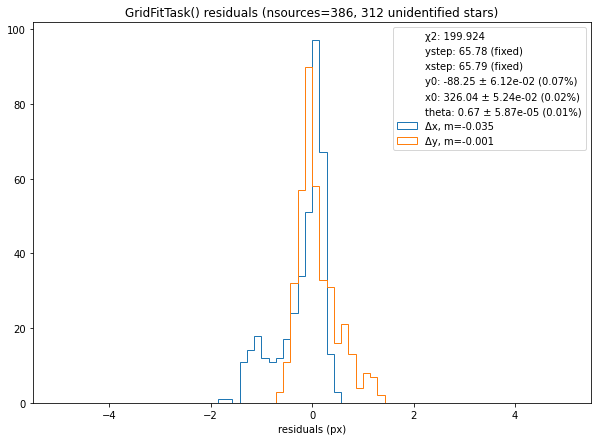

In [5]:
residualsX, residualsY, nSources, nUnidentifiedPoints, outliersX, outliersY = fit_check(gridfit_task.srcX,gridfit_task.srcY,gX,gY, 'E2V')

plt.figure(1, figsize=(10,7))
plt.hist(residualsX, bins=70, range=(-5,5), histtype='step', label='Δx, ' + "m=" + str(round(np.median(residualsX), 3)), log=False)
plt.hist(residualsY, bins=70, range=(-5,5), histtype='step', label='Δy, ' + "m=" + str(round(np.median(residualsY), 3)), log=False)
plt.xlabel("residuals (px)")
plt.plot([], [], ' ', label="χ2: " + str(round(result.chisqr, 3)))

for name in result.params:
    p = result.params[name]
    if p.vary:
        label = p.name + ": " + str(round(p.value,2)) + " ± " + str('{:.2e}'.format(p.stderr)) + ' ({:.2%})'.format(abs(p.stderr/p.value)) 
    else:
        label = p.name + ": " + str(round(p.value,2)) + " (fixed)"

    plt.plot([], [], ' ', label=label)

plt.legend()
plt.title("GridFitTask() residuals (nsources=" + str(nSources) + ", " + str(nUnidentifiedPoints) + " unidentified stars" + ")")
plt.savefig("test-"+ str(i) + "-fit.png")

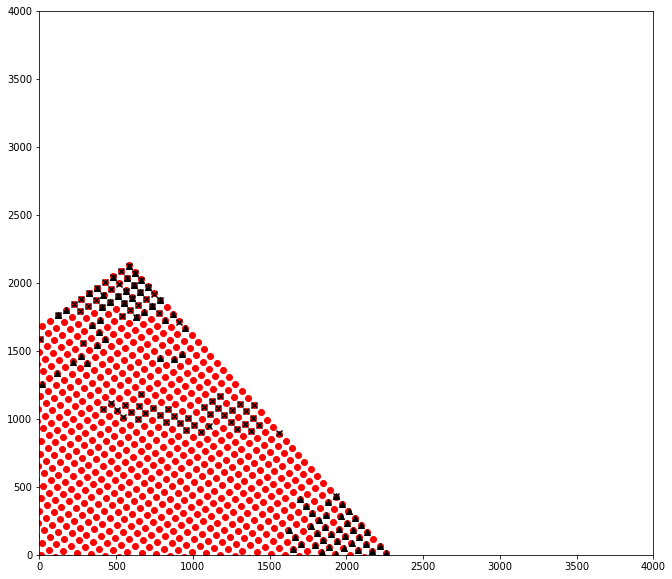

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(11, 10))
ax.scatter(gX, gY, color='red', marker='o')
#ax.scatter(gridfit_task.srcX, gridfit_task.srcY, color='blue', marker='x')
ax.scatter([t[0] for t in outliersX], [t[1] for t in outliersX], color='k', marker='^')
ax.scatter([t[0] for t in outliersY], [t[1] for t in outliersY], color='k', marker='x')
ax.set_xlim(0,4000)
ax.set_ylim(0,4000)
plt.savefig("test-" + str(i) + ".png")

(0.0, 4000.0)

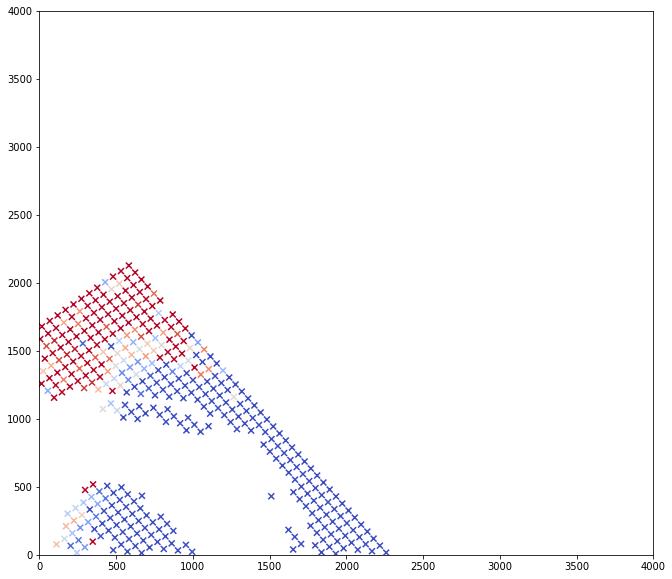

In [13]:
import matplotlib.cm as cm
residualsX = np.asarray(residualsX)
residualsY = np.asarray(residualsY)
x = np.asarray(gridfit_task.srcX)
y = np.asarray(gridfit_task.srcY)
index = np.argsort(residualsX)
x = x[index]
y = y[index]
colors = cm.coolwarm(np.linspace(-2, 2, len(residualsX)))

fig = plt.figure(1, figsize=(11, 10))
plt.scatter(x, y, color=colors, marker='x')
plt.xlim(0,4000)
plt.ylim(0,4000)


(0.0, 4000.0)

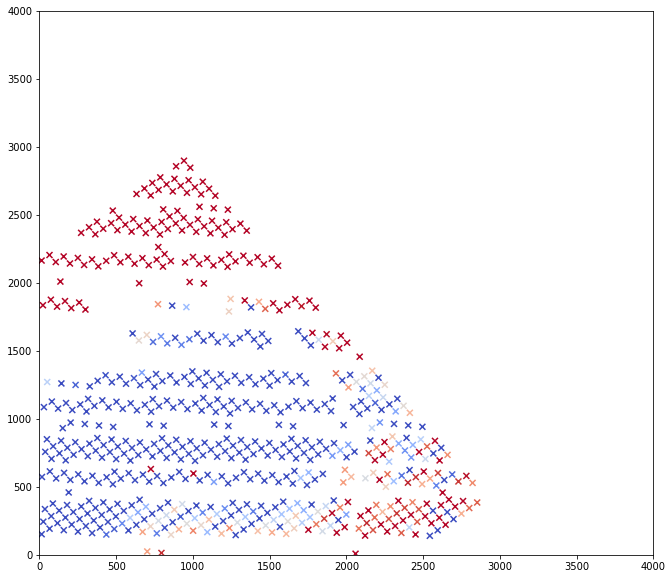

In [11]:
residualsX = np.asarray(residualsX)
residualsY = np.asarray(residualsY)
x = np.asarray(gridfit_task.srcX)
y = np.asarray(gridfit_task.srcY)
index = np.argsort(residualsY)
x = x[index]
y = y[index]
colors = cm.coolwarm(np.linspace(-2, 2, len(residualsX)))

fig, ax = plt.subplots(1, 1, figsize=(11, 10))
ax.scatter(x, y, color=colors, marker='x')
ax.set_xlim(0,4000)
ax.set_ylim(0,4000)